# Event finder 

This notebook will find "events" in the simplest definition i.e. a loser cell apoptosis or a winner cell 

To-do: 
- [x] Input HDF5 file which includes necessary information of x, y, t, fate
- [x] Identify a loser apoptosis x, y, t by invoking tracks[1] for Scr cells and sorting via fate by using tracks[1].fate
- [x] Define the exact time point of a loser cell apoptosis, how many frames it is classed as an apoptosis before the actual event (mainly ensuring false apoptoses aren’t included) 
- [ ] Screen all other tracks in the vicinity of previously obtained x, y, t by using if statement
- [ ] Screen further by excluding all tracks[0].fate =! division
- [ ] Repeat if statement for differing spatiotemporal ‘local environments’, increasing x, y, t  to count instances of mitosis across the whole monolayer over the whole experiment. 
- [ ] Assess viability of capturing a whole experiment in a single heat map, reduce scope if this is unviable. 

Refreshed to-do/different approach: 
- [x] find competitive event using list comprehension
- [x] remember how to find cells not using index but cell ID
- [x] write a function that parses that track(?) and finds local cells nearby


### Load data

In [1]:
import btrack
print("version no.:", btrack.__version__)
from btrack.utils import import_HDF, import_JSON
import numpy as np

version no.: 0.3.13


In [2]:
filename ='/home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5'
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_1") as h:
    wt_tracks = h.tracks
with btrack.dataio.HDF5FileHandler(filename, 'r', obj_type = "obj_type_2") as h:
    scr_tracks = h.tracks
#scr_tracks = (tracks[1]) 
#wt_tracks = (tracks[0]) #initially, tracks[0] is the tracks for cell type 0 (ie, WT or Scr etc)
print("Track information loaded")

[INFO][2020/11/17 12:44:19 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/17 12:44:19 PM] Loading tracks/obj_type_1
[INFO][2020/11/17 12:44:24 PM] Loading objects/obj_type_1 (408973, 5) (388394 filtered: area>=100)
[INFO][2020/11/17 12:44:32 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5
[INFO][2020/11/17 12:44:32 PM] Opening HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5...
[INFO][2020/11/17 12:44:32 PM] Loading tracks/obj_type_2
[INFO][2020/11/17 12:44:32 PM] Loading objects/obj_type_2 (12115, 5) (8894 filtered: area>=100)
[INFO][2020/11/17 12:44:32 PM] Closing HDF file: /home/nathan/data/kraken/h2b/giulia/GV0807/Pos3/Pos3_aligned/HDF/segmented.hdf5


Track information loaded


## Find event

#### Display track information

In [3]:
### this list comp shows scr cell IDs that have apoptosed and their length
[print("ID:", scr_track.ID, scr_track.fate.name, "length:", len(scr_track), "final time point:", scr_track.t[-1])  for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

ID: 1 APOPTOSIS length: 913 final time point: 912
ID: 3 APOPTOSIS length: 1176 final time point: 1175
ID: 4 APOPTOSIS length: 1175 final time point: 1174
ID: 6 APOPTOSIS length: 91 final time point: 91
ID: 10 APOPTOSIS length: 54 final time point: 171
ID: 11 APOPTOSIS length: 16 final time point: 175
ID: 16 APOPTOSIS length: 706 final time point: 1059
ID: 17 APOPTOSIS length: 388 final time point: 742
ID: 18 APOPTOSIS length: 199 final time point: 573
ID: 29 APOPTOSIS length: 349 final time point: 920
ID: 38 APOPTOSIS length: 3 final time point: 729
ID: 46 APOPTOSIS length: 7 final time point: 766
ID: 47 APOPTOSIS length: 167 final time point: 935
ID: 50 APOPTOSIS length: 371 final time point: 1175
ID: 54 APOPTOSIS length: 18 final time point: 900
ID: 56 APOPTOSIS length: 291 final time point: 1175
ID: 58 APOPTOSIS length: 289 final time point: 1175
ID: 60 APOPTOSIS length: 3 final time point: 892
ID: 65 APOPTOSIS length: 55 final time point: 967
ID: 66 APOPTOSIS length: 3 final time p

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Filter tracks to only include scr apoptosis

In [4]:
### scr_apop is all the scr tracks that have apoptosed
scr_apops = [scr_track for scr_track in scr_tracks if scr_track.fate.name == "APOPTOSIS"]

#### Display track ID alongside list index

In [5]:
[print("apoptosis ID", scr_apop.ID, "index", i) for i, scr_apop in enumerate(scr_apops)]

apoptosis ID 1 index 0
apoptosis ID 3 index 1
apoptosis ID 4 index 2
apoptosis ID 6 index 3
apoptosis ID 10 index 4
apoptosis ID 11 index 5
apoptosis ID 16 index 6
apoptosis ID 17 index 7
apoptosis ID 18 index 8
apoptosis ID 29 index 9
apoptosis ID 38 index 10
apoptosis ID 46 index 11
apoptosis ID 47 index 12
apoptosis ID 50 index 13
apoptosis ID 54 index 14
apoptosis ID 56 index 15
apoptosis ID 58 index 16
apoptosis ID 60 index 17
apoptosis ID 65 index 18
apoptosis ID 66 index 19
apoptosis ID 67 index 20
apoptosis ID 71 index 21
apoptosis ID 72 index 22
apoptosis ID 74 index 23
apoptosis ID 78 index 24
apoptosis ID 82 index 25
apoptosis ID 85 index 26
apoptosis ID 87 index 27
apoptosis ID 90 index 28
apoptosis ID 96 index 29
apoptosis ID 98 index 30
apoptosis ID 99 index 31
apoptosis ID 100 index 32
apoptosis ID 102 index 33
apoptosis ID 105 index 34
apoptosis ID 111 index 35
apoptosis ID 112 index 36
apoptosis ID 119 index 37
apoptosis ID 120 index 38
apoptosis ID 122 index 39
apopto

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

#### Set a variable of index dependent on cell choice to facilitate retrieval of this cell ID later

In [6]:
print("Input cell ID of interest")
cell_ID = int(input())
index = [i for i, scr_apop in enumerate(scr_apops) if scr_apop.ID == cell_ID][0]

Input cell ID of interest
17


In [7]:
### .label indicates progression of cell phase classification
scr_apops[index].label 


['ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'ANAPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHASE',
 'INTERPHAS

In [8]:
# get track ID 17, print xyt 
print("ID is", scr_apops[index].ID)
# loser_event_x = scr_apop[index].x
# loser_event_y = scr_apop[index].y
# loser_event_t = scr_apop[index].t

loser_event_x, loser_event_y, loser_event_t = scr_apops[index].x, scr_apops[index].y, scr_apops[index].t

print(loser_event_x[0], loser_event_y[0], loser_event_t[0], loser_event_t[-1])

ID is 17
592.0890502929688 1121.349365234375 354 742


#### Isolating one track of interest

In [9]:
print("Input cell ID of interest")
cell_ID = int(input())
index = [i for i, scr_apop in enumerate(scr_apops) if scr_apop.ID == cell_ID][0]
target_track = scr_apops[index]

Input cell ID of interest
17


## Find nearby cells 

In [10]:
target_track

,ID,t,x,y,z,parent,root,state,generation,dummy
0,17,354,592.089050,1121.349365,0.000000,2,2,3,1,False
1,17,355,599.770813,1122.750000,0.000000,2,2,3,1,False
2,17,356,597.294983,1122.762573,0.000000,2,2,3,1,False
3,17,357,595.140930,1121.939575,0.000000,2,2,3,1,False
4,17,358,596.659119,1121.590942,0.000000,2,2,3,1,False
5,17,359,598.070312,1123.187500,0.000000,2,2,3,1,False
6,17,360,601.812317,1124.481201,0.000000,2,2,3,1,False
7,17,361,606.079834,1126.327026,0.000000,2,2,3,1,False
8,17,362,608.422485,1126.737915,0.000000,2,2,0,1,False
9,17,363,610.502502,1127.165894,0.000000,2,2,0,1,False


### Functions to measure local neighbourhood for cells of interest

In [13]:
def euclidean_distance(target_track, other_track, frame):
    try:
        idx0 = target_track.t.index(frame)
        idx1 = other_track.t.index(frame)
    except:
        return np.inf
    
    dx = target_track.x[idx0] - other_track.x[idx1]
    dy = target_track.y[idx0] - other_track.y[idx1]
    
    return np.sqrt(dx**2 + dy**2)

def find_apoptosis_index(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            #apop_other_index = target_track.label.index("APOPTOSIS") ## this doesnt return the first of three classifications like i need
            break
    return apop_index

#### merge with above for two outputs?
def find_apoptosis_time(target_track):
    for i, j in enumerate(target_track.label):
        if j == 'APOPTOSIS' and target_track.label[i+1] == 'APOPTOSIS' and target_track.label[i+2] == 'APOPTOSIS': # and target_track.label[i+3] =='APOPTOSIS' and target_track.label[i+4] =='APOPTOSIS':
            apop_index = i
            break
    apop_time = target_track.t[apop_index]
    return apop_time

def find_nearby_wt(target_track, radius = 100, delta_t = 0):
    frame = apop_time + delta_t ## check the delta_t option 
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]##not strictly necessary to have this extra conditional bc scr/wt_tracks are different anyway #and wt_track != target_track]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    
    return wt_tracks_in_radius

def find_nearby_wt_mitosis(target_track, delta_t, radius = 100):
    frame = apop_time + delta_t ## check the delta_t option 
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]##not strictly necessary to have this extra conditional bc scr/wt_tracks are different anyway #and wt_track != target_track]
    wt_mitosis_fate_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius and wt_track.fate.name == "DIVIDE"] ## change this to divide within time point
    
    return wt_mitosis_fate_in_radius

In [14]:
apop_index = find_apoptosis_index(target_track)
apop_time = find_apoptosis_time(target_track)
nearby_cells = find_nearby_wt(target_track)
nearby_mitosis = find_nearby_wt_mitosis(target_track, 100)

# to do

- [?] thus far i have nearby tracks that END in a mitosis, but i need nearby tracks that have a mitosis within delta_t of apop_time
- [x] put a circle of radius r on the diagram below

In [91]:
[ID.fate.name for ID in nearby_cells]

['DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'DIVIDE',
 'FALSE_POSITIVE']

In [345]:
def find_nearby_wt_mitosis(target_track, delta_t, radius = 500):
    frame = apop_time + delta_t 
    dividing_states = ('PROMETAPHASE', 'METAPHASE', 'DIVIDE')
    wt_tracks_in_frame = [wt_track for wt_track in wt_tracks if wt_track.in_frame(frame)]
    wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]
    wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] in dividing_states]

    return wt_mitosis_in_radius


In [321]:
#### old nearby list, created issue with list entry
delta_t = 200
old_nearby = []
for t in range(-delta_t, delta_t):
    old_nearby.append(find_nearby_wt_mitosis(target_track, t))
    old_nearby = list(filter(None, old_nearby))
for i, j in enumerate(nearby): ### BAD HACK needs solving: each entry in the nearby list is entered as a list itself, not a btrack tracklet, so need to redefine as first item in list
    old_nearby[i] = old_nearby[i][0] 

In [357]:
delta_t = 1
nearby = []
for t in range(-delta_t, delta_t):
    nearby += find_nearby_wt_mitosis(target_track, t)

In [358]:
len(nearby)

8

In [359]:
for track in nearby:
    print(track.ID) 

445
462
468
550
615
765
1005
1001


# display tracks

In [77]:
import matplotlib.pyplot as plt

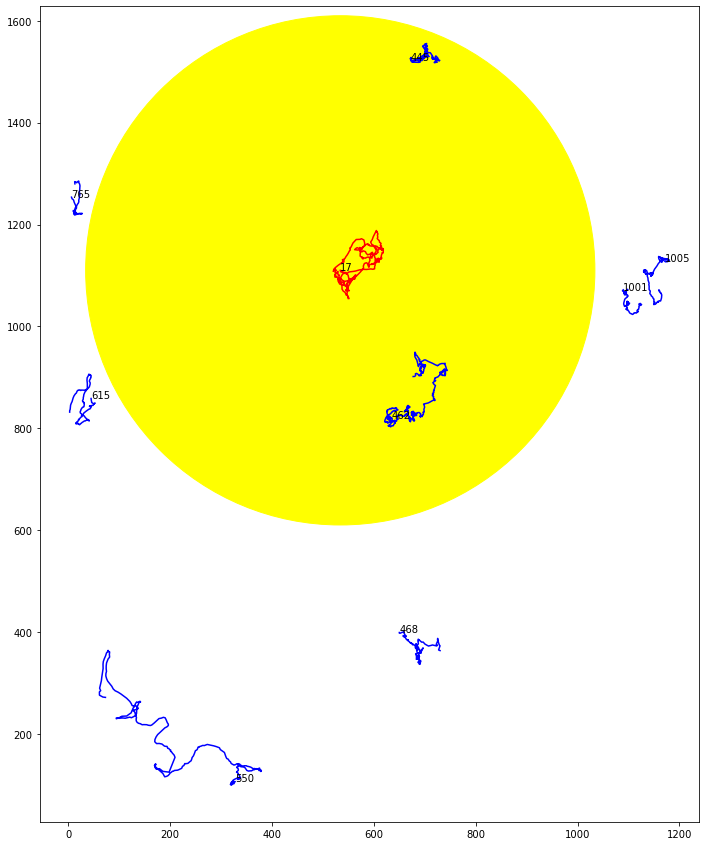

In [361]:
figure, axes = plt.subplots()
draw_circle = plt.Circle((target_track.x[-1], target_track.y[-1]), 500,fill=True, color = 'yellow')
plt.plot(target_track.x, target_track.y, 'r-')
plt.text(target_track.x[-1], target_track.y[-1], target_track.ID)
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
    plt.text(track.x[-1], track.y[-1], track.ID)
axes.set_aspect(1)
axes.add_artist(draw_circle)
# plt.xlim(0,1200)
# plt.ylim(0,1200)
figure.set_size_inches(15, 15)
plt.show()

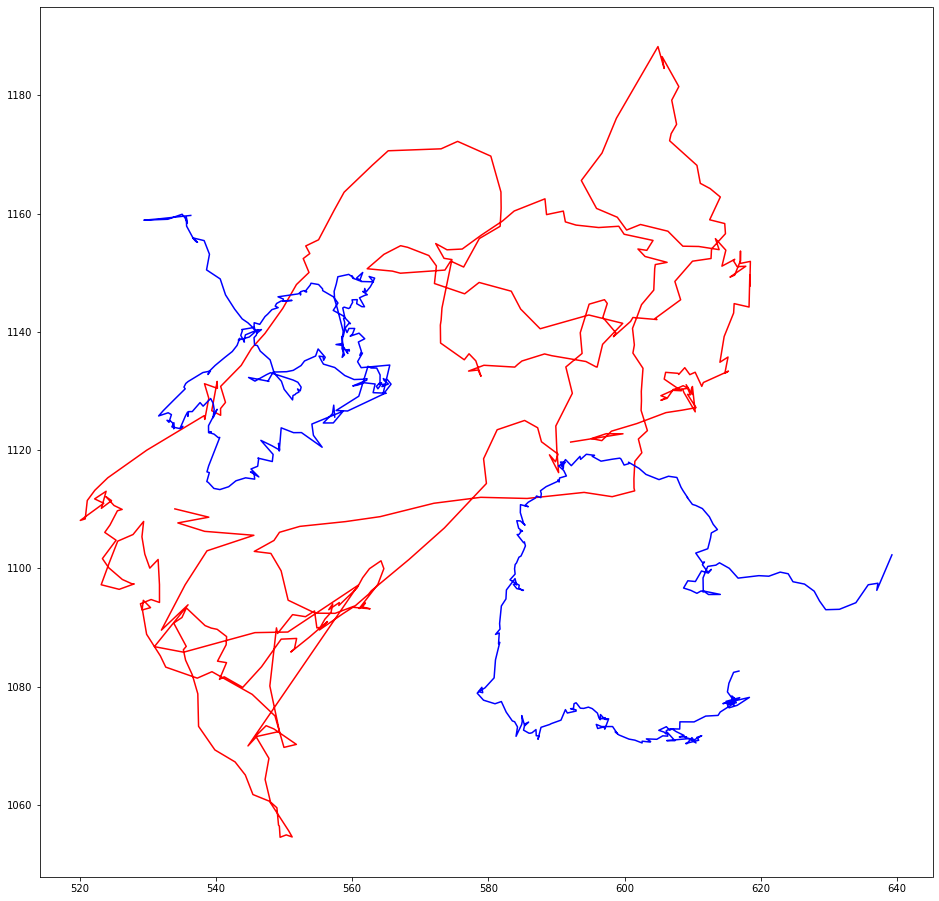

In [276]:
plt.figure(figsize=(16,16))
plt.plot(target_track.x, target_track.y, 'r-')
for track in nearby:
    plt.plot(track.x, track.y, 'b-')
# for mitosis in nearby_mitosis:
#     plt.plot(mitosis.x, mitosis.y, 'g-')


plt.show()

###### misc

In [254]:
#### old nearby list, created issue with list entry
delta_t = 2
old_nearby = []
for t in range(-delta_t, delta_t):
    old_nearby.append(find_nearby_wt_mitosis(target_track, t))
    old_nearby = list(filter(None, old_nearby))
# for i, j in enumerate(nearby): ### BAD HACK needs solving: each entry in the nearby list is entered as a list itself, not a btrack tracklet, so need to redefine as first item in list
#     nearby[i] = nearby[i][0] 

In [ ]:
### ideas i showed guillaume when explaining plan, keeping for future reference

wt_track.label[apop_time] == "DIVIDE"
nearby_mitosis_plust = find_nearby_wt_mitosis(target_track, 200)

In [ ]:
print(target_track.label)
apop_frames = [i for i, j in enumerate(target_track.label) if j == "APOPTOSIS"]
target_track.label[-1]

In [ ]:
wt_tracks[0].label

In [ ]:
wt_tracks_in_radius = [wt_track for wt_track in wt_tracks_in_frame if euclidean_distance(target_track, wt_track, frame)<radius]

want the below conditional to be ```if wt_track.label[wt_track.t.index(apop_time +- delta_t)] == "APOPTOSIS"```

In [ ]:
### want the conditional to be if wt
wt_mitosis_in_radius = [wt_track for wt_track in wt_tracks_in_radius if wt_track.label[wt_track.t.index(frame)] == "DIVIDE"]

In [ ]:
##rewriting the list comprehension as a for loop to see if the conditional statement can be achieved

for wt_track in wt_tracks_in_radius:
    if wt_track.fate.name == "DIVIDE":
        
        if wt_track.label[wt_track.t.index(apop_time)] == "DIVIDE":
        ### something to store a mitosis at apop_time
    if wt_track

In [ ]:
wt_track.label[0] ## here we have the state at index 0, and want the state at t = apop_t

## want label at t
track = wt_tracks_in_frame[0]
track_2 = wt_tracks_in_frame[-1]

In [ ]:
### this line pulls the classification from the apoptosis time
track.label[track.t.index(apop_time)]

In [ ]:
### this pulls the index from the time
track.t.index(apop_time)

In [ ]:
target_track.label[target_track.t.index(apop_time)]

In [ ]:
target_track

In [ ]:
apop_time

In [ ]:
wt_tracks_in_frame[0]

In [ ]:
wt_tracks_in_frame[-]